In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import AutoModel
from transformers import PreTrainedTokenizer
from transformers import AdamW
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
from rdkit import Chem
from SmilesPE.tokenizer import *
import codecs
from SmilesPE.learner import *
from typing import List, Optional
import os
import collections
from tokenizer_spe import *

In [2]:
df = pd.read_csv('FULL_VALID_CAN_SMILES_DATASET.csv')
print(df.shape)
df.head()

(94335, 5)


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501


In [3]:
#Character Level Tokenization
def tokenize_smiles_char(smiles):
    return [char for char in smiles]

df['char_level_tokenize'] = df['CAN_SMILES'].apply(tokenize_smiles_char)
all_chars = [char for sublist in df['char_level_tokenize'].tolist() for char in sublist]
char_counts = Counter(all_chars)
print("Total Uniue characters in dataset",len(char_counts))
unique_chars = char_counts.keys()
print(unique_chars)

# Create a character vocabulary and mappings to/from integers
char_to_int = {char: i for i, char in enumerate(unique_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

def char_encode_smiles(tokenized_smiles):
    return [char_to_int[char] for char in tokenized_smiles]

df['char_level_encoded'] = df['char_level_tokenize'].apply(char_encode_smiles)
df.head()


Total Uniue characters in dataset 36
dict_keys(['C', '#', 'c', '1', '[', 'n', 'H', ']', 's', '2', '-', '3', '(', '=', 'O', ')', 'N', 'F', '4', '/', '\\', 'S', 'o', 'e', 'i', '5', '6', 'B', 'r', 'l', 'P', '+', '\t', '\n', 'G', '@'])


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ..."
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2..."
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ..."
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,..."
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,..."


In [4]:
#Atomic level tokenization
def atomic_smiles_tokenizer(smi, exclusive_tokens=None):
    """
    Tokenize a SMILES molecule at atom-level:
        (1) 'Br' and 'Cl' are two-character tokens.
        (2) Symbols with brackets are considered as tokens.
        (3) Optionally replace non-exclusive bracketed tokens with '[UNK]'.

    Parameters:
        smi (str): The SMILES string to tokenize.
        exclusive_tokens (list of str, optional): Specific symbols with brackets to keep. 
            All other bracketed symbols are replaced with '[UNK]'. Default is None.

    Returns:
        list of str: The tokenized SMILES.

    Raises:
        AssertionError: If the reconstructed SMILES does not match the original input.
    """
    smi = smi.strip()
    pattern = "(\[[^\]]+\]|Br|Cl|C|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = regex.findall(smi)

    if exclusive_tokens:
        tokens = [tok if tok in exclusive_tokens or not tok.startswith('[') else '[UNK]' for tok in tokens]

    reconstructed_smi = ''.join(tokens)
    assert smi == reconstructed_smi, f"Tokenization mismatch: {smi} != {reconstructed_smi}"
    return tokens


df['atom_level_tokenize'] = df['CAN_SMILES'].apply(atomic_smiles_tokenizer)
all_atoms = [atom for sublist in df['atom_level_tokenize'].tolist() for atom in sublist]
atom_counts = Counter(all_atoms)
print("Total Unique Atoms in Dataset:", len(atom_counts))
unique_atoms = atom_counts.keys()
print(unique_atoms)

atom_to_int = {atom: i + 1 for i, atom in enumerate(sorted(unique_atoms))}
int_to_atom = {i: atom for atom, i in atom_to_int.items()}

def atomic_encode_smiles(tokenized_smiles):
    return [atom_to_int[atom] for atom in tokenized_smiles if atom!=',']  

# Encode the tokenized SMILES strings
df['atom_level_encoded'] = df['atom_level_tokenize'].apply(atomic_encode_smiles)
df.head()

Total Unique Atoms in Dataset: 50
dict_keys(['C', '#', 'c', '1', '[nH]', 's', '2', '-', '3', '(', '=', 'O', ')', 'N', 'F', '4', '/', '\\', 'S', 'o', 'n', '[se]', '[SiH2]', '5', '6', 'Br', 'Cl', 'P', '[N+]', '[O-]', '[n+]', '[N-]', '[C-]', '[NH-]', '[GeH2]', '[C@@H]', '[C@@]', '[C@H]', '[CH]', '[C]', '[S@]', '[S@@]', '[Se]', '[c]', '[S]', '[CH2]', '[SH]', '[C@]', '[N]', '[n]'])


,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded,atom_level_tokenize,atom_level_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ...","[C, #, C, c, 1, [nH], c, c, c, 1, c, 1, c, s, ...","[14, 1, 14, 47, 6, 43, 47, 47, 47, 6, 47, 6, 4..."
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2...","[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[18, 12, 14, 6, 47, 7, 47, 2, 4, 47, 8, 47, 6,..."
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ...","[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[14, 47, 6, 50, 47, 7, 4, 47, 8, 50, 47, 47, 4..."
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,...","[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[18, 12, 17, 2, 12, 18, 3, 47, 6, 47, 47, 7, 4..."
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,...","[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[14, 47, 6, 47, 47, 7, 47, 2, 4, 47, 8, 47, 2,..."


In [5]:
#Data driven Tokenization
#SPE Tokenization
spe_vob= codecs.open('SPE_data.txt')
spe = SPE_Tokenizer(spe_vob)
# some default tokens from huggingface
default_toks = ['[PAD]', 
                '[unused1]', '[unused2]', '[unused3]', '[unused4]','[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', 
                '[UNK]', '[CLS]', '[SEP]', '[MASK]']


# atom-level tokens 
atom_tokens = ['O', '=', 'C', '1', '2', '(', 'S', ')', '3', '4', '[NH]', '#', '5', '6', 'F',
                '[N]', '\\', '/', '[S]', 'N', '[Se]', '[CH2]', '[C]', '[CH]', '[SiH2]', '7', '8', 'Br', 'Cl', 
                '[P]', '[N+]', '[O-]', '[SH]', '9', '%10', '%11', '%12', '[N-]', 'P', ':', '[PH]', '[C-]', '[NH-]',
                'c', 's', 'n', 'o','[se]', '[nH]', '[GeH2]', '[C@@H]', '[C@@]', '[C@H]', '[S@]', '[S@@]', '[c]', '[C@]', '[n]']
# spe tokens
with open('SPE_data.txt', "r") as ins:
    spe_toks = []
    for line in ins:
        spe_toks.append(line.split('\n')[0])

spe_tokens = []
for s in spe_toks:
    spe_tokens.append(''.join(s.split(' ')))
    
spe_vocab = default_toks + atom_tokens + spe_tokens
with open('vocab_spe.txt', 'w') as f:
    for voc in spe_vocab:
        f.write(f'{voc}\n')
spe_tokenizer = SMILES_SPE_Tokenizer(vocab_file='vocab_spe.txt', spe_file= 'SPE_data.txt')
def spe_encode_smiles(smiles):
    try:
        encoded = spe_tokenizer(smiles)
        return encoded['input_ids']
    except Exception as e:
        print(f"Error encoding SMILES {smiles}: {str(e)}")
        return None
df['data_driven_encoded'] = df['CAN_SMILES'].apply(spe_encode_smiles)

In [35]:
len(spe_vocab)


572

In [6]:
smi_1 = 'CC[N+](C)(C)Cc1ccccc1Br'
smi_2 = 'c1cccc1[invalid]'
encoded_input = spe_tokenizer(smi_1)
spe_tokenizer.decode(encoded_input["input_ids"])

'[CLS] CC [N+] (C) (C)C c1ccccc1 Br [SEP]'

In [34]:
encoded_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [7]:
df.head()

,E_homo,E_lumo,KS_gap,CAN_SMILES,MW,char_level_tokenize,char_level_encoded,atom_level_tokenize,atom_level_encoded,data_driven_encoded
0,-5.17017,-2.28848,2.88169,C#Cc1[nH]ccc1c1csc2-c3c(C(=O)c12)ccs3,281.352,"[C, #, C, c, 1, [, n, H, ], c, c, c, 1, c, 1, ...","[0, 1, 0, 2, 3, 4, 5, 6, 7, 2, 2, 2, 3, 2, 3, ...","[C, #, C, c, 1, [nH], c, c, c, 1, c, 1, c, s, ...","[14, 1, 14, 47, 6, 43, 47, 47, 47, 6, 47, 6, 4...","[12, 429, 212, 115, 225, 13]"
1,-5.29262,-2.47624,2.81638,O=C1c2c(-c3c1ccs3)scc2c1c2sccc2cc2c1ccs2,380.526,"[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[14, 13, 0, 3, 2, 9, 2, 12, 10, 2, 11, 2, 3, 2...","[O, =, C, 1, c, 2, c, (, -, c, 3, c, 1, c, c, ...","[18, 12, 14, 6, 47, 7, 47, 2, 4, 47, 8, 47, 6,...","[12, 557, 300, 133, 59, 161, 91, 182, 19, 13]"
2,-5.30622,-2.40005,2.90617,Cc1sc2-c3sccc3C(=O)c2c1C1=CC(=C)c2c1csc2,338.466,"[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[0, 2, 3, 8, 2, 9, 10, 2, 11, 8, 2, 2, 2, 11, ...","[C, c, 1, s, c, 2, -, c, 3, s, c, c, c, 3, C, ...","[14, 47, 6, 50, 47, 7, 4, 47, 8, 50, 47, 47, 4...","[12, 17, 420, 185, 289, 82, 393, 13]"
3,-5.99195,-2.91162,3.08033,O=N(=O)c1cc2c(s1)c(sc2C(F)(F)F)c1csc2-c3c(C(=O...,443.463,"[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[14, 13, 16, 12, 13, 14, 15, 2, 3, 2, 2, 9, 2,...","[O, =, N, (, =, O, ), c, 1, c, c, 2, c, (, s, ...","[18, 12, 17, 2, 12, 18, 3, 47, 6, 47, 47, 7, 4...","[12, 344, 293, 142, 79, 164, 225, 13]"
4,-5.31983,-2.44086,2.87897,Cc1cc2c(-c3c(C2=O)c(cs3)c2cc(ccc2N(=O)=O)c2csc...,409.501,"[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[0, 2, 3, 2, 2, 9, 2, 12, 10, 2, 11, 2, 12, 0,...","[C, c, 1, c, c, 2, c, (, -, c, 3, c, (, C, 2, ...","[14, 47, 6, 47, 47, 7, 47, 2, 4, 47, 8, 47, 2,...","[12, 17, 560, 276, 161, 190, 454, 175, 265, 13]"


In [19]:
char_X = list(df['char_level_encoded'])
atom_X = list(df['atom_level_encoded'])
spe_X = list(df['data_driven_encoded'])
def pad_sequences(sequences, max_len):
    # Pad each sequence with -1 up to max_len
    return np.array([seq + [-1] * (max_len - len(seq)) if len(seq) < max_len else seq for seq in sequences])

max_length_char = max(len(seq) for seq in char_X)
max_length_atom = max(len(seq) for seq in atom_X)
max_length_spe = max(len(seq) for seq in spe_X)

# Pad all sequences to their respective maximum lengths
char_X_padded = pad_sequences(char_X, max_length_char)
atom_X_padded = pad_sequences(atom_X, max_length_atom)
spe_X_padded = pad_sequences(spe_X, max_length_spe)

y = df[['E_homo', 'E_lumo']].values

# Splitting each encoding type into training and testing sets
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(char_X_padded, y, test_size=0.2, random_state=42)
X_train_atom, X_test_atom, y_train_atom, y_test_atom = train_test_split(atom_X_padded, y, test_size=0.2, random_state=42)
X_train_spe, X_test_spe, y_train_spe, y_test_spe = train_test_split(spe_X_padded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

y_train_char = scaler.fit_transform(y_train_char)  
y_test_char = scaler.transform(y_test_char)  
y_train_atom = scaler.fit_transform(y_train_atom)
y_test_atom = scaler.transform(y_test_atom)
y_train_spe = scaler.fit_transform(y_train_spe)
y_test_spe = scaler.transform(y_test_spe)

In [21]:
# Train a model for char-level encoding
model_char = RandomForestRegressor(n_estimators=100, random_state=42)
model_char.fit(X_train_char, y_train_char)

# Train a model for atom-level encoding
model_atom = RandomForestRegressor(n_estimators=100, random_state=42)
model_atom.fit(X_train_atom, y_train_atom)

# Train a model for SPE encoding
model_spe = RandomForestRegressor(n_estimators=100, random_state=42)
model_spe.fit(X_train_spe, y_train_spe)


RandomForestRegressor(random_state=42)

In [23]:
def evaluate_and_save(model, scaler, X_train, y_train, X_test, y_test, filename):
    #predict train data
    y_train_pred = scaler.inverse_transform(model.predict(X_train).reshape(-1, 2))
    y_train_actual = scaler.inverse_transform(y_train)
    
    # Predict test data
    y_test_pred = scaler.inverse_transform(model.predict(X_test).reshape(-1, 2))
    y_test_actual = scaler.inverse_transform(y_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train_actual, y_train_pred)
    mse_test = mean_squared_error(y_test_actual, y_test_pred)
    r2_train = r2_score(y_train_actual, y_train_pred)
    r2_test = r2_score(y_test_actual, y_test_pred)
    
    # Save test predictions and actual values to CSV
    test_results = pd.DataFrame({
        'E_homo_actual': y_test_actual[:, 0],
        'E_lumo_actual': y_test_actual[:, 1],
        'E_homo_predicted': y_test_pred[:, 0],
        'E_lumo_predicted': y_test_pred[:, 1]
    })
    test_results.to_csv(filename, index=False)
    
    return (y_train_actual, y_train_pred, mse_train, r2_train,
            y_test_actual, y_test_pred, mse_test, r2_test)

# Evaluate each model and save results
evaluate_and_save(model_char, scaler, X_train_char, y_train_char, X_test_char, y_test_char, 'rf_char_level_predictions.csv')

(array([[-5.67358, -0.20681],
        [-6.3076 , -0.48436],
        [-6.40556,  0.55239],
        ...,
        [-6.011  , -1.36329],
        [-5.1484 , -2.2395 ],
        [-5.47221, -2.77012]]),
 array([[-5.6629662, -0.4431124],
        [-6.0175546, -0.9919898],
        [-6.4578621, -0.3907562],
        ...,
        [-6.1355732, -1.4045431],
        [-5.2106858, -2.2201791],
        [-5.4657068, -2.7251136]]),
 0.028236328758644465,
 0.9502623496331357,
 array([[-5.82052, -2.75107],
        [-5.88855, -0.17687],
        [-6.22053, -1.15921],
        ...,
        [-6.54434, -0.41361],
        [-5.23547, -0.63403],
        [-6.09808, -1.3252 ]]),
 array([[-5.7254141, -2.689575 ],
        [-5.8354852, -0.5572644],
        [-6.0370943, -1.0796935],
        ...,
        [-6.0617477, -0.4768259],
        [-5.6564329, -1.1470963],
        [-5.7125984, -1.3075898]]),
 0.19952496699331312,
 0.6483692377355963)

In [24]:
evaluate_and_save(model_atom, scaler, X_train_atom, y_train_atom, X_test_atom, y_test_atom, 'rf_atom_level_predictions.csv')

(array([[-5.67358, -0.20681],
        [-6.3076 , -0.48436],
        [-6.40556,  0.55239],
        ...,
        [-6.011  , -1.36329],
        [-5.1484 , -2.2395 ],
        [-5.47221, -2.77012]]),
 array([[-5.6666938, -0.4108402],
        [-6.0116497, -0.8714979],
        [-6.6190081, -0.6022705],
        ...,
        [-6.0751642, -1.2649213],
        [-5.1778959, -2.1932127],
        [-5.5025508, -2.7996999]]),
 0.028336293999986342,
 0.9506270360398212,
 array([[-5.82052, -2.75107],
        [-5.88855, -0.17687],
        [-6.22053, -1.15921],
        ...,
        [-6.54434, -0.41361],
        [-5.23547, -0.63403],
        [-6.09808, -1.3252 ]]),
 array([[-5.7133867, -2.6596955],
        [-5.8401658, -0.5696182],
        [-5.9600037, -0.97297  ],
        ...,
        [-6.1375326, -0.4145928],
        [-5.7049497, -1.5055783],
        [-5.6909931, -1.2509346]]),
 0.20040756833072962,
 0.6506763142370613)

In [25]:
evaluate_and_save(model_spe, scaler, X_train_spe, y_train_spe, X_test_spe, y_test_spe, 'rf_spe_level_predictions.csv')

(array([[-5.67358, -0.20681],
        [-6.3076 , -0.48436],
        [-6.40556,  0.55239],
        ...,
        [-6.011  , -1.36329],
        [-5.1484 , -2.2395 ],
        [-5.47221, -2.77012]]),
 array([[-5.7648186, -0.6768311],
        [-6.0459093, -0.9507919],
        [-6.3277098, -0.3098574],
        ...,
        [-6.1556553, -1.5178509],
        [-5.1889709, -2.2340292],
        [-5.4952858, -2.7254135]]),
 0.03646980734975406,
 0.9372994701206285,
 array([[-5.82052, -2.75107],
        [-5.88855, -0.17687],
        [-6.22053, -1.15921],
        ...,
        [-6.54434, -0.41361],
        [-5.23547, -0.63403],
        [-6.09808, -1.3252 ]]),
 array([[-5.6549642, -2.6022802],
        [-5.8783704, -0.5993598],
        [-5.8593758, -1.5093357],
        ...,
        [-6.0944283, -0.3527434],
        [-5.6211135, -1.4850619],
        [-5.686666 , -1.1833987]]),
 0.25724185321188275,
 0.5582568943626611)

In [36]:
def plot_results(filename, x_min_homo, x_max_homo, y_min_homo, y_max_homo, x_min_lumo, x_max_lumo, y_min_lumo, y_max_lumo):
    data = pd.read_csv(filename)
    
    # Calculate MSE for HOMO and LUMO
    mse_homo = mean_squared_error(data['E_homo_actual'], data['E_homo_predicted'])
    mse_lumo = mean_squared_error(data['E_lumo_actual'], data['E_lumo_predicted'])
    r2_homo = r2_score(data['E_homo_actual'], data['E_homo_predicted'])
    r2_lumo = r2_score(data['E_lumo_actual'], data['E_lumo_predicted'])
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot HOMO predictions
    axs[0].scatter(data['E_homo_actual'], data['E_homo_predicted'], color='blue', label='HOMO')
    axs[0].plot([x_min_homo, x_max_homo], [y_min_homo, y_max_homo], 'k--', lw=2, label='Ideal Line')
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    axs[0].set_title(f'HOMO Prediction\nMSE: {mse_homo:.3f}, R2: {r2_homo:.3f}')
    axs[0].set_xlim(x_min_homo, x_max_homo)
    axs[0].set_ylim(y_min_homo, y_max_homo)
    axs[0].legend()

    # Plot LUMO predictions
    axs[1].scatter(data['E_lumo_actual'], data['E_lumo_predicted'], color='red', label='LUMO')
    axs[1].plot([x_min_lumo, x_max_lumo], [y_min_lumo, y_max_lumo], 'k--', lw=2, label='Ideal Line')
    axs[1].set_xlabel('Actual')
    axs[1].set_ylabel('Predicted')
    axs[1].set_title(f'LUMO Prediction\nMSE: {mse_lumo:.2f}, R2: {r2_lumo:.3f}')
    axs[1].set_xlim(x_min_lumo, x_max_lumo)
    axs[1].set_ylim(y_min_lumo, y_max_lumo)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


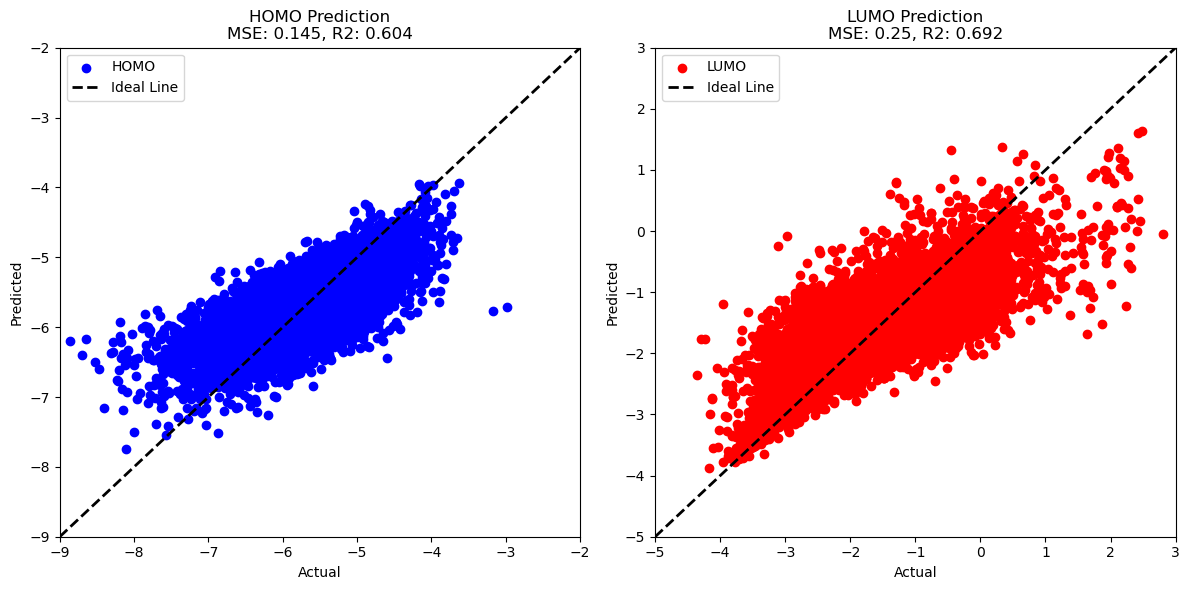

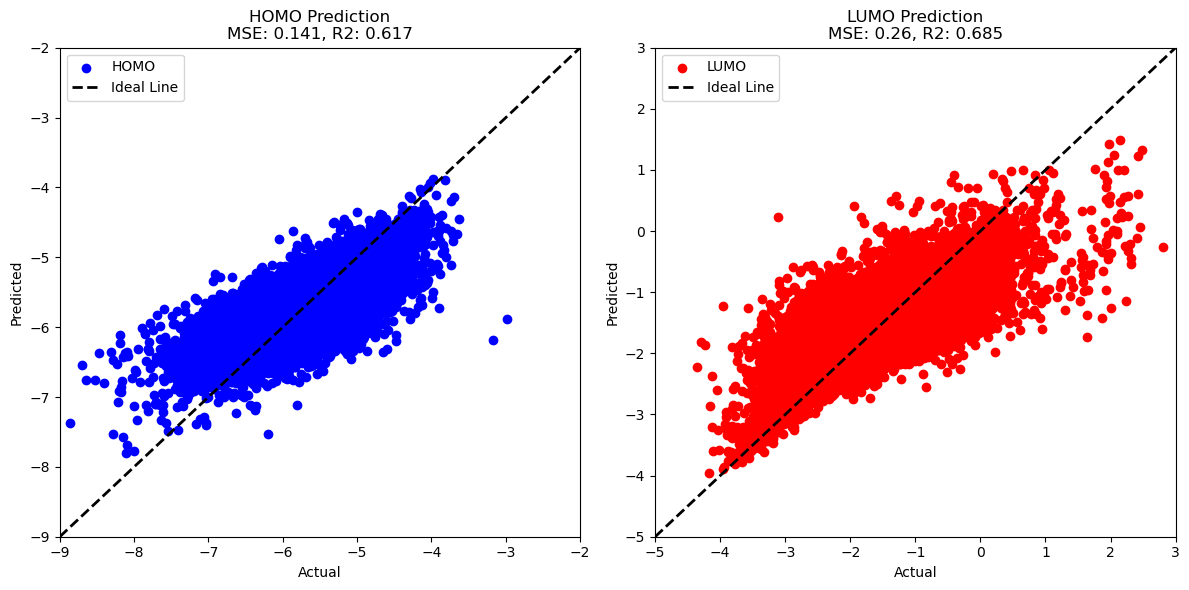

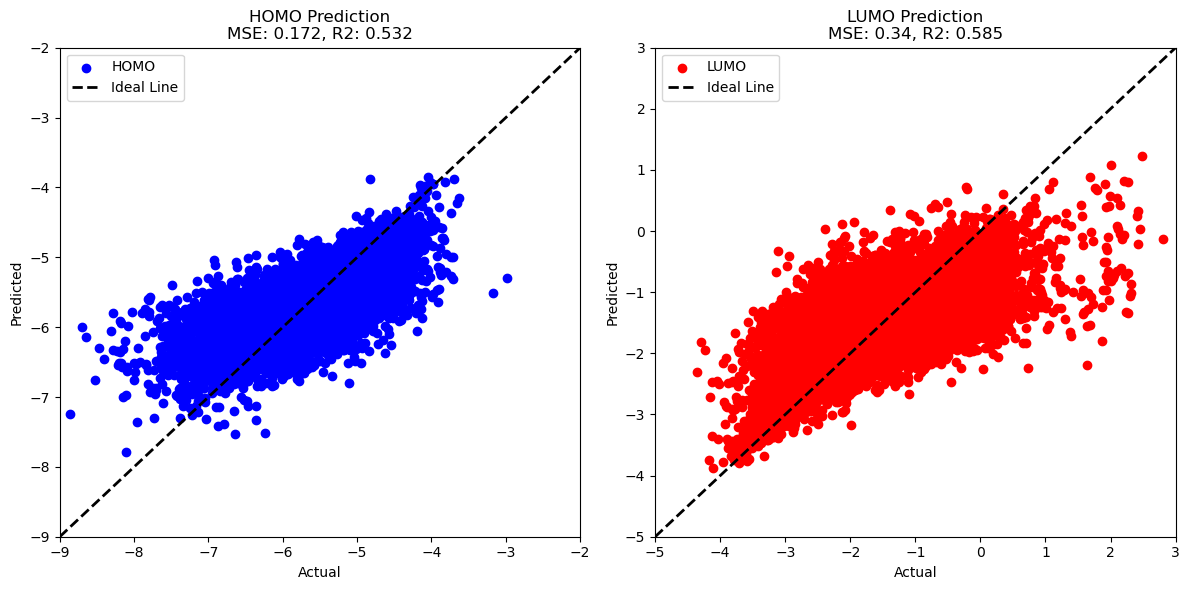

In [37]:
# For Char-Level Predictions
plot_results('rf_char_level_predictions.csv', -9, -2, -9, -2,-5, 3, -5, 3)

plot_results('rf_atom_level_predictions.csv', -9, -2, -9, -2,-5, 3, -5, 3)

plot_results('rf_spe_level_predictions.csv', -9, -2, -9, -2,-5, 3, -5, 3)
